In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from plot_keras_history import show_history, plot_history


import logging
logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [3]:
img_dir = 'Flipkart/Images/'

In [4]:
data = pd.read_csv('dataframe_pictures.csv')
data.head()

,product_category_tree,image,label
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,6
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,3
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,3
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,6
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,6


In [5]:
l_cat = ['Home Furnishing', 'Baby Care', 'Home Decor & Festive Needs', 'Beauty and Personal Care', 'Watches', 'Kitchen & Dining', 'Computers']

In [6]:
data_train, data_test = train_test_split(data, stratify=data['product_category_tree'], test_size=0.20, random_state=42)
data_train.reset_index(inplace=True, drop=True)
data_test.reset_index(inplace=True, drop=True)
print(f'data_train : {data_train.shape}')
print(f'data_test : {data_test.shape}')

data_train : (840, 3)
data_test : (210, 3)


# Création du modèle de classification

In [8]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

# Approche préparation initiale des images

In [7]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image'])) :
        img = (load_img(
            img_dir + str(data['image'][image_num]),
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(data_train)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

C:\Users\olivi\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(840, 224, 224, 3)
(210, 224, 224, 3)


In [11]:
X = images_np
y = to_categorical(data_train['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
X_train.shape

(672, 224, 224, 3)

In [13]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 5.4870 - accuracy: 0.4568
Epoch 1: val_loss improved from inf to 1.12753, saving model to .\model1_best_weights.h5
11/11 [==============================] - 15s 748ms/step - loss: 5.4870 - accuracy: 0.4568 - val_loss: 1.1275 - val_accuracy: 0.7560
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.9542 - accuracy: 0.6830
Epoch 2: val_loss improved from 1.12753 to 0.91868, saving model to .\model1_best_weights.h5
11/11 [==============================] - 2s 162ms/step - loss: 1.9542 - accuracy: 0.6830 - val_loss: 0.9187 - val_accuracy: 0.8036
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.3188 - accuracy: 0.7366
Epoch 3: val_loss improved from 0.91868 to 0.81553, saving model to .\model1_best_weights.h5
11/11 [==============================] - 2s 160ms/step - loss: 1.3188 - accuracy: 0.7366 - val_loss: 0.8155 - val_accuracy: 0.8214
Epoch 4/50
11/11 [==============================]

In [57]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

21/21 [==============================] - 31s 1s/step - loss: 0.0089 - accuracy: 1.0000
Training Accuracy: 1.0000

6/6 [==============================] - 8s 1s/step - loss: 0.7041 - accuracy: 0.8333
Validation Accuracy:  0.8333


In [58]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8274
Test Accuracy       :  0.8095


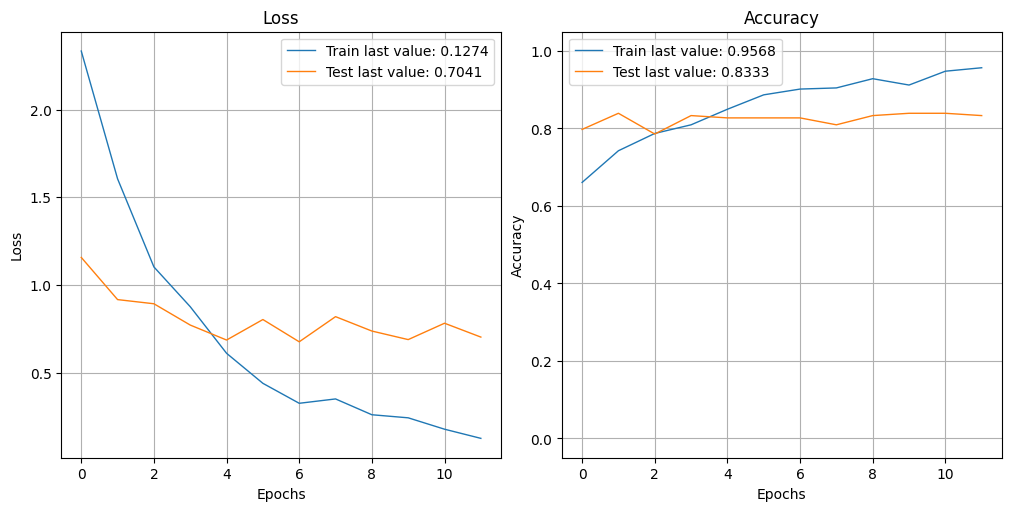

In [60]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [61]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

6/6 [==============================] - 8s 1s/step
[2 5 3 2 2 2 1 1 6 5 1 5 6 5 6 3 0 2 6 4 2 0 0 6 4 6 3 0 3 4 0 0 1 6 5 4 6
 3 1 4 0 2 6 1 0 6 6 5 2 3 5 5 2 4 5 6 4 6 5 4 0 1 1 5 1 6 0 0 5 0 2 4 3 1
 5 0 3 2 3 3 6 0 5 3 3 1 1 1 4 1 5 2 3 2 4 5 3 2 4 5 4 6 3 5 2 0 5 2 3 1 0
 1 0 1 5 3 1 5 3 1 5 1 0 5 3 1 4 4 2 6 2 2 4 3 3 1 0 6 0 4 3 1 4 1 6 2 6 5
 0 0 6 6 2 6 4 2 3 2 2 4 4 3 0 4 4 6 4 0]

[6 5 3 2 2 5 1 5 6 5 1 5 6 5 6 5 1 2 6 4 2 1 3 5 4 6 3 0 4 4 0 0 2 6 5 4 6
 3 1 4 0 2 6 0 0 6 6 5 2 5 5 5 2 4 5 6 4 6 5 4 0 1 3 5 1 6 0 0 6 0 2 4 3 1
 6 0 3 2 3 3 6 0 5 2 3 1 6 1 4 1 5 2 3 2 4 5 3 2 4 5 4 6 3 5 2 0 5 2 3 0 0
 1 0 1 5 3 1 5 3 0 5 0 0 5 3 1 4 4 2 6 6 2 4 6 3 1 0 2 0 6 3 0 3 0 6 2 6 2
 0 0 6 6 2 6 4 2 3 2 2 4 4 3 0 4 4 6 4 2]


In [64]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[20  2  1  1  0  0  0]
 [ 6 14  1  1  0  1  1]
 [ 0  0 21  0  0  1  2]
 [ 0  0  1 19  1  2  1]
 [ 0  0  0  1 22  0  1]
 [ 0  0  1  0  0 21  2]
 [ 0  0  1  0  0  1 22]]


In [82]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [86]:
y_val_num

array([2, 5, 3, 2, 2, 2, 1, 1, 6, 5, 1, 5, 6, 5, 6, 3, 0, 2, 6, 4, 2, 0,
       0, 6, 4, 6, 3, 0, 3, 4, 0, 0, 1, 6, 5, 4, 6, 3, 1, 4, 0, 2, 6, 1,
       0, 6, 6, 5, 2, 3, 5, 5, 2, 4, 5, 6, 4, 6, 5, 4, 0, 1, 1, 5, 1, 6,
       0, 0, 5, 0, 2, 4, 3, 1, 5, 0, 3, 2, 3, 3, 6, 0, 5, 3, 3, 1, 1, 1,
       4, 1, 5, 2, 3, 2, 4, 5, 3, 2, 4, 5, 4, 6, 3, 5, 2, 0, 5, 2, 3, 1,
       0, 1, 0, 1, 5, 3, 1, 5, 3, 1, 5, 1, 0, 5, 3, 1, 4, 4, 2, 6, 2, 2,
       4, 3, 3, 1, 0, 6, 0, 4, 3, 1, 4, 1, 6, 2, 6, 5, 0, 0, 6, 6, 2, 6,
       4, 2, 3, 2, 2, 4, 4, 3, 0, 4, 4, 6, 4, 0], dtype=int64)

In [91]:
X_val.shape

(168, 224, 224, 3)

In [85]:
y_val_pred_transform

0      6
1      5
2      3
3      2
4      2
      ..
163    4
164    4
165    6
166    4
167    2
Name: y_pred_transform, Length: 168, dtype: int64

In [83]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[20  2  1  1  0  0  0]
 [ 6 14  1  1  0  1  1]
 [ 0  0 21  0  0  1  2]
 [ 0  0  1 19  1  2  1]
 [ 0  0  0  1 22  0  1]
 [ 0  0  1  0  0 21  2]
 [ 0  0  1  0  0  1 22]]

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        24
           1       0.88      0.58      0.70        24
           2       0.81      0.88      0.84        24
           3       0.86      0.79      0.83        24
           4       0.96      0.92      0.94        24
           5       0.81      0.88      0.84        24
           6       0.76      0.92      0.83        24

    accuracy                           0.83       168
   macro avg       0.83      0.83      0.82       168
weighted avg       0.83      0.83      0.82       168



<Axes: >

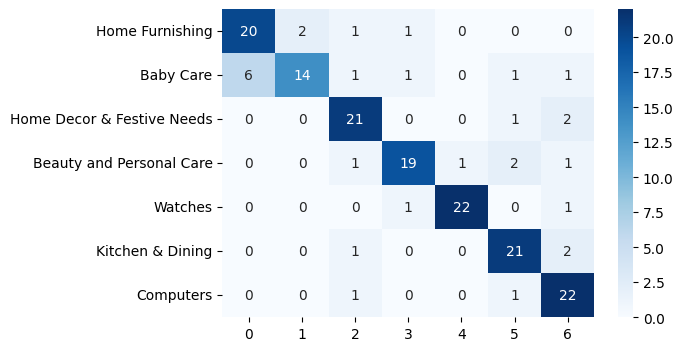

In [84]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# Approche ImageDatagenerator avec data augmentation

In [19]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory=img_dir,
                                x_col='image', y_col='product_category_tree',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [20]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 788 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [21]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [22]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
10/25 [===========>..................] - ETA: 5s - loss: 5.4826 - accuracy: 0.3701

C:\Users\olivi\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


25/25 [==============================] - ETA: 0s - loss: 3.6050 - accuracy: 0.5051
Epoch 1: val_loss improved from inf to 2.03696, saving model to .\model2_best_weights.h5
25/25 [==============================] - 14s 531ms/step - loss: 3.6050 - accuracy: 0.5051 - val_loss: 2.0370 - val_accuracy: 0.5000
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.4550 - accuracy: 0.6701
Epoch 2: val_loss improved from 2.03696 to 1.73653, saving model to .\model2_best_weights.h5
25/25 [==============================] - 13s 504ms/step - loss: 1.4550 - accuracy: 0.6701 - val_loss: 1.7365 - val_accuracy: 0.5534
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.0630 - accuracy: 0.7411
Epoch 3: val_loss improved from 1.73653 to 1.67271, saving model to .\model2_best_weights.h5
25/25 [==============================] - 13s 509ms/step - loss: 1.0630 - accuracy: 0.7411 - val_loss: 1.6727 - val_accuracy: 0.5649
Epoch 4/50
25/25 [==============================] - ETA: 0

In [23]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

25/25 [==============================] - 10s 371ms/step - loss: 0.1128 - accuracy: 0.9695
Training Accuracy   : 0.9695

9/9 [==============================] - 3s 327ms/step - loss: 1.5349 - accuracy: 0.6718
Validation Accuracy :  0.6718


In [24]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7099
Test Accuracy       :  0.9095


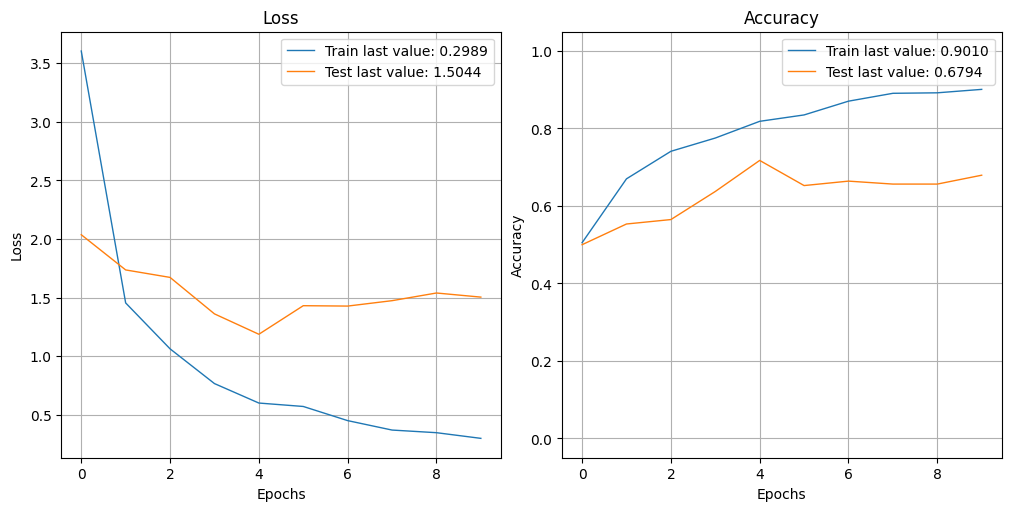

In [25]:
show_history(history2)
plot_history(history2, path="standard.png")
plt
plt.close()

# Approche nouvelle par Dataset sans data augmentation

In [11]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [26]:
### ONLY ONCE TO SETUP THE DIRECTORIES AND FILES

import shutil

# Creating Train / Test folders
for categ in l_cat:
    os.makedirs(img_dir + '/train//' + categ)
    os.makedirs(img_dir + '/test//' + categ)

for index, row in data_train.iterrows():
    shutil.copy(img_dir + str(row['image']), img_dir + '/train//' + str(row['product_category_tree']))
    
for index, row in data_test.iterrows():
    shutil.copy(img_dir + str(row['image']), img_dir + '/test//' + str(row['product_category_tree']))

FileExistsError: [WinError 183] Impossible de créer un fichier déjà existant: 'Flipkart/Images//train//Home Furnishing'

In [13]:
path_train = "Flipkart/Images/train/"
path_test = "Flipkart/Images/test/"

dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [28]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [29]:
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 6.9360 - accuracy: 0.4619
Epoch 1: val_loss improved from inf to 1.36974, saving model to .\model3_best_weights.h5
20/20 [==============================] - 15s 619ms/step - loss: 6.9360 - accuracy: 0.4619 - val_loss: 1.3697 - val_accuracy: 0.7857
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 2.4380 - accuracy: 0.6619
Epoch 2: val_loss improved from 1.36974 to 1.21787, saving model to .\model3_best_weights.h5
20/20 [==============================] - 8s 285ms/step - loss: 2.4380 - accuracy: 0.6619 - val_loss: 1.2179 - val_accuracy: 0.8048
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.5932 - accuracy: 0.7492
Epoch 3: val_loss improved from 1.21787 to 0.99820, saving model to .\model3_best_weights.h5
20/20 [==============================] - 6s 220ms/step - loss: 1.5932 - accuracy: 0.7492 - val_loss: 0.9982 - val_accuracy: 0.7952
Epoch 4/50
20/20 [==============================]

In [30]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 4s 123ms/step - loss: 0.0060 - accuracy: 0.9984
Training Accuracy   : 0.9984

7/7 [==============================] - 3s 98ms/step - loss: 0.9510 - accuracy: 0.8381
Validation Accuracy :  0.8381


In [31]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8476
Test Accuracy       :  0.7476


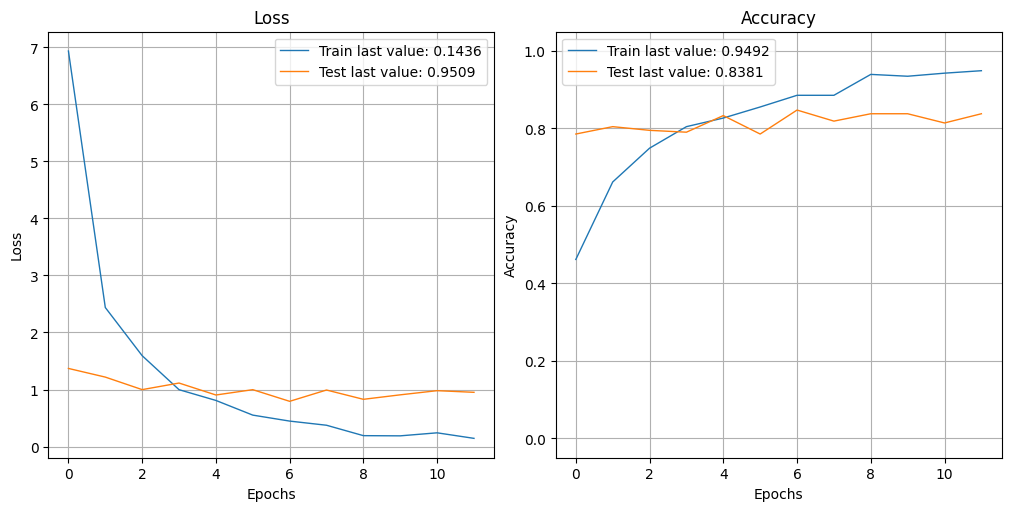

In [32]:
show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

# Approche nouvelle par Dataset avec data augmentation intégrée au modèle

In [7]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [18]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        #Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [19]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [20]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.9564 - accuracy: 0.2111
Epoch 1: val_loss improved from inf to 1.53156, saving model to .\model4_best_weights.h5
20/20 [==============================] - 7s 223ms/step - loss: 1.9564 - accuracy: 0.2111 - val_loss: 1.5316 - val_accuracy: 0.5429
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.4987 - accuracy: 0.4889
Epoch 2: val_loss improved from 1.53156 to 1.14893, saving model to .\model4_best_weights.h5
20/20 [==============================] - 5s 215ms/step - loss: 1.4987 - accuracy: 0.4889 - val_loss: 1.1489 - val_accuracy: 0.6857
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.2242 - accuracy: 0.6063
Epoch 3: val_loss improved from 1.14893 to 0.94709, saving model to .\model4_best_weights.h5
20/20 [==============================] - 5s 218ms/step - loss: 1.2242 - accuracy: 0.6063 - val_loss: 0.9471 - val_accuracy: 0.7667
Epoch 4/50
20/20 [==============================] 

In [21]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 2s 76ms/step - loss: 0.3065 - accuracy: 0.9000
Training Accuracy   : 0.9000

7/7 [==============================] - 1s 62ms/step - loss: 0.5238 - accuracy: 0.8238
Validation Accuracy :  0.8238


In [22]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8381
Test Accuracy       :  0.7667


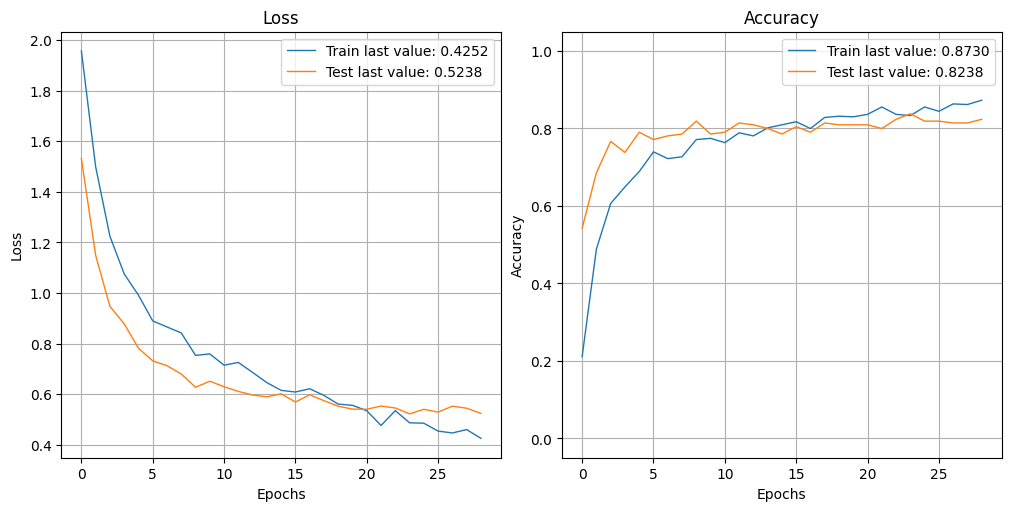

In [23]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

# Entrainement des derniers poids

In [46]:
def create_model_fct3() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers[:-2]:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [47]:
# Création du modèle
with tf.device('/gpu:0'): 
    model5 = create_model_fct3()

# Création du callback
model5_save_path = "./model5_best_weights.h5"
checkpoint = ModelCheckpoint(model5_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                      

In [48]:
with tf.device('/gpu:0'): 
    history5 = model5.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.6833 - accuracy: 0.3937
Epoch 1: val_loss improved from inf to 1.01726, saving model to .\model5_best_weights.h5
20/20 [==============================] - 13s 375ms/step - loss: 1.6833 - accuracy: 0.3937 - val_loss: 1.0173 - val_accuracy: 0.6952
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.0185 - accuracy: 0.6587
Epoch 2: val_loss improved from 1.01726 to 0.87742, saving model to .\model5_best_weights.h5
20/20 [==============================] - 9s 336ms/step - loss: 1.0185 - accuracy: 0.6587 - val_loss: 0.8774 - val_accuracy: 0.7333
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.9124 - accuracy: 0.6984
Epoch 3: val_loss improved from 0.87742 to 0.72607, saving model to .\model5_best_weights.h5
20/20 [==============================] - 8s 286ms/step - loss: 0.9124 - accuracy: 0.6984 - val_loss: 0.7261 - val_accuracy: 0.7286
Epoch 4/50
20/20 [==============================]

In [49]:
# Score du dernier epoch

loss, accuracy = model5.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model5.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 3s 81ms/step - loss: 0.1671 - accuracy: 0.9429
Training Accuracy   : 0.9429

7/7 [==============================] - 2s 68ms/step - loss: 0.6441 - accuracy: 0.8095
Validation Accuracy :  0.8095


In [51]:
# Score de l'epoch optimal

model5.load_weights(model5_save_path)

loss, accuracy = model5.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model5.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8143
Test Accuracy       :  0.7571


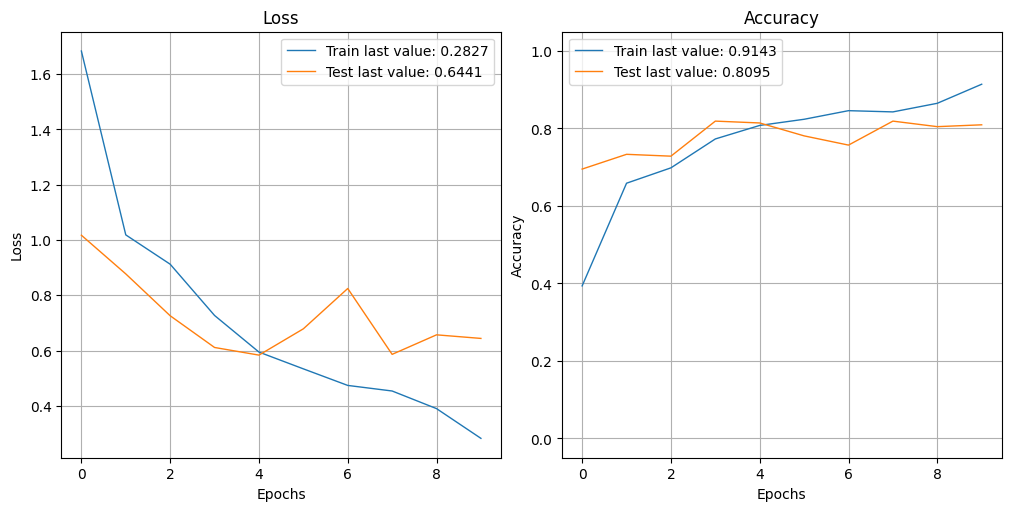

In [52]:
show_history(history5)
plot_history(history5, path="standard.png")
plt.close()